In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from datetime import datetime, timedelta
from sklearn.metrics import mean_squared_error
from math import sqrt
import warnings

warnings.filterwarnings("ignore")


*Loading Data*

In [ ]:
from quantrocket.license import set_license
set_license("93c815d1-e078-11ee-80c7-2f600d78117c")

{'licensekey': '93c8........117c', 'software_license': {}}

In [ ]:
from quantrocket.master import collect_usstock_listings
collect_usstock_listings()

{'status': 'success', 'msg': 'already up-to-date'}

In [ ]:
from quantrocket.master import get_securities
securities = get_securities(symbols='AAPL', fields=['Sid', 'Symbol', 'Exchange'], vendors='usstock')
securities

,Symbol,Exchange
Sid,,
FIBBG000B9XRY4,AAPL,XNAS


In [ ]:
from quantrocket.zipline import create_usstock_bundle
create_usstock_bundle("usstock-free1",free = True)

{'status': 'success', 'msg': 'successfully created usstock-free1 bundle'}

In [ ]:
from quantrocket.zipline import ingest_bundle
ingest_bundle("usstock-free1")

{'status': 'the data will be ingested asynchronously'}

In [ ]:
from quantrocket import get_prices
data = get_prices("usstock-free1", data_frequency='daily', sids="FIBBG000B9XRY4", start_date='2023-01-01', end_date='2023-12-31', fields=["Close"])

In [ ]:
data.to_csv('usstockaapl.csv')

In [2]:
data=pd.read_csv('usstockaapl.csv')
data

,Field,Date,FIBBG000B9XRY4
0,Close,2023-01-03,124.375
1,Close,2023-01-04,125.658
2,Close,2023-01-05,124.325
3,Close,2023-01-06,128.900
4,Close,2023-01-09,129.427
...,...,...,...
245,Close,2023-12-22,193.600
246,Close,2023-12-26,193.050
247,Close,2023-12-27,193.150
248,Close,2023-12-28,193.580


In [3]:
data.rename(columns={"FIBBG000B9XRY4":"Close"},inplace=True) #Changing the Column Name

**Class Description:**

A class to model the behavior of a financial market based on daily closing prices.

**Attributes:**

- **data (DataFrame):** The financial data containing 'Date' and 'Close' columns.
- **returns (list):** List to store daily returns.
- **state (list):** List to store market states (1 for bull, 0 for flat, -1 for bear).
- **portfolio_values (list):** List to store portfolio values over time.
- **optimal_buys (list):** List to store indices of optimal buying opportunities.

**Function Definitions:**

- **calculate_state():**
    Calculate daily returns and determine market states based on returns.

- **calculate_portfolio_values():**
    Calculate portfolio values based on market states and store optimal buying indices.

- **visualize_transition_probability():**
    Visualize the transition probability distribution between different market states.

- **decide_buy():**
    Decide whether to buy stock based on the change in portfolio value.


In [4]:
class Model:
    def __init__(self, data):
        self.data = data
        self.returns = []
        self.state = []
        self.portfolio_values = []
        self.optimal_buys=[]

    def calculate_state(self):
        self.returns.append(1)
        self.state.append(1)
        for i in range(1, len(self.data)):
            rd = (self.data.iloc[i]['Close'] - self.data.iloc[i - 1]['Close']) / self.data.iloc[i - 1]['Close']
            self.returns.append(rd)
            if rd >= 0.01:
                self.state.append(1)
            elif rd > (-1 * 0.01):
                self.state.append(0)
            else:
                self.state.append(-1)

    def calculate_portfolio_values(self):
        self.optimal_buys=[1]
        self.calculate_state()
        self.portfolio_values = [0]
        for i in range(1, len(self.state)):
            if self.state[i] == 1 and self.state[i - 1] == 0:
                self.portfolio_values.append(self.portfolio_values[i - 1] + 1)
                self.optimal_buys.append(i)
            elif self.state[i] == -1 and self.state[i - 1] == 0:
                self.portfolio_values.append(self.portfolio_values[i - 1] - 1)
            else:
                self.portfolio_values.append(self.portfolio_values[i - 1])
    def visualize_transition_probability(self):
        self.calculate_portfolio_values()
        probability_distribution = {}
        for i in range(len(self.state) - 1):
            transition = (self.state[i], self.state[i+1])
            if transition not in probability_distribution:
                probability_distribution[transition] = 1
            else:
                probability_distribution[transition] += 1

        # Calculate row sums
        row_sums = {}
        for transition, count in probability_distribution.items():
            current_state = transition[0]
            if current_state not in row_sums:
                row_sums[current_state] = count
            else:
                row_sums[current_state] += count

        # Normalize counts
        for transition, count in probability_distribution.items():
            current_state = transition[0]
            probability_distribution[transition] = count / row_sums[current_state]

        # Create transition probability matrix
        matrix = [[0 for _ in range(3)] for _ in range(3)]
        for i in probability_distribution:
            matrix[i[0]+1][i[1]+1] = probability_distribution[i]

        labels = ["Bear", "Flat", "Bull"]

        # Create heatmap
        plt.figure(figsize=(8, 6))
        sns.heatmap(matrix, annot=True, cmap='coolwarm', fmt=".2f", cbar=True, xticklabels=labels, yticklabels=labels)
        plt.title('Transition Probability Distribution')
        plt.xlabel('Next State')
        plt.ylabel('Previous State')
        plt.show()

        # Print matrix with indices
        print("Matrix with Indices:")
        print("{:<10} {:<10} {:<10} {:<10}".format("", *labels))
        for i, row in enumerate(matrix):
            print("{:<10} {:<10.2f} {:<10.2f} {:<10.2f}".format(labels[i], *row))
        print('Portfolio_value : ',self.portfolio_values[-1])
        dates=[]
        for i in self.optimal_buys:
          dates.append(data.iloc[i]['Date'])
        print('Buy_Indices : ',self.optimal_buys)
        print('Buy_Dates : ',dates)
    def decide_buy(self):
      if self.portfolio_values[-2]<self.portfolio_values[-1]:
        print("We can buy Stock on that Day")
      else:
        print("Dont buy Stock on that Day")


In [5]:
model=Model(data)

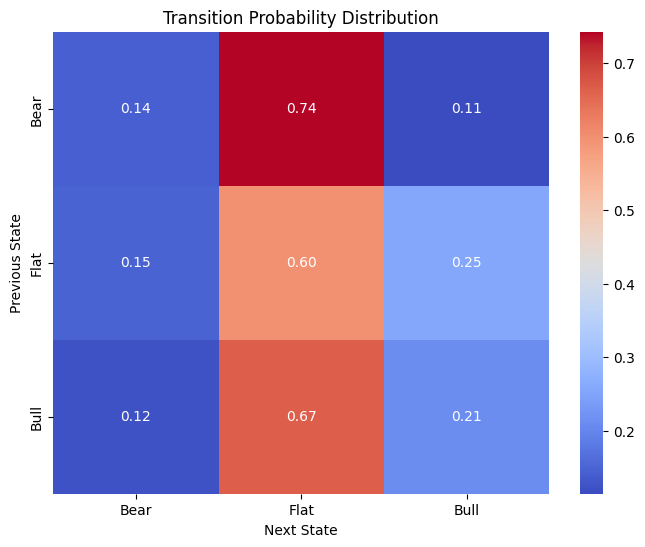

Matrix with Indices:
           Bear       Flat       Bull      
Bear       0.14       0.74       0.11      
Flat       0.15       0.60       0.25      
Bull       0.12       0.67       0.21      
Portfolio_value :  17
Buy_Indices :  [1, 6, 8, 12, 16, 21, 28, 30, 41, 50, 52, 59, 61, 69, 79, 85, 88, 94, 100, 103, 108, 110, 113, 117, 120, 123, 133, 142, 160, 164, 177, 187, 191, 207, 209, 212, 216, 218, 232, 234, 238]
Buy_Dates :  ['2023-01-04', '2023-01-11', '2023-01-13', '2023-01-20', '2023-01-26', '2023-02-02', '2023-02-13', '2023-02-15', '2023-03-03', '2023-03-16', '2023-03-20', '2023-03-29', '2023-03-31', '2023-04-13', '2023-04-27', '2023-05-05', '2023-05-10', '2023-05-18', '2023-05-26', '2023-06-01', '2023-06-08', '2023-06-12', '2023-06-15', '2023-06-22', '2023-06-27', '2023-06-30', '2023-07-17', '2023-07-28', '2023-08-23', '2023-08-29', '2023-09-18', '2023-10-02', '2023-10-06', '2023-10-30', '2023-11-01', '2023-11-06', '2023-11-10', '2023-11-14', '2023-12-05', '2023-12-07', '2023-1

In [6]:
model.visualize_transition_probability()

**Plot : showing stocks data and a 30-day moving average**

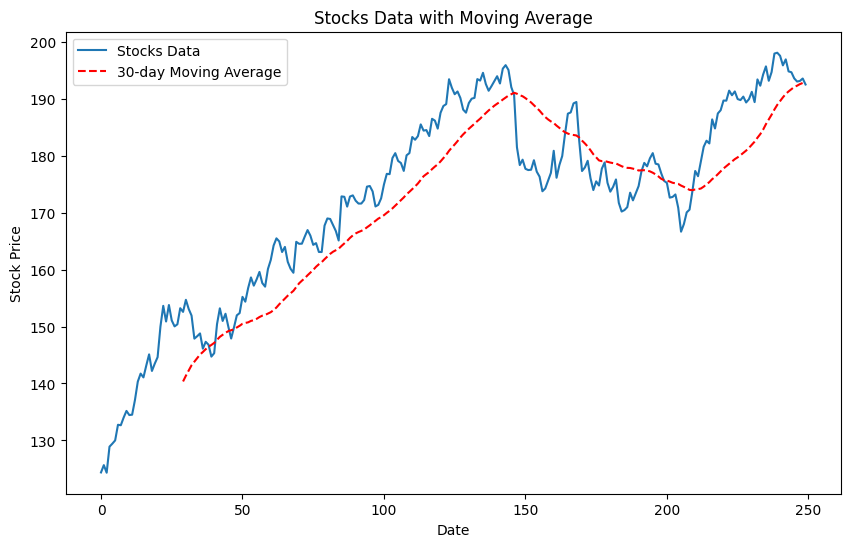

In [7]:
# Plot time series data
plt.figure(figsize=(10, 6))
plt.plot(data['Close'], label='Stocks Data')

# Calculate and plot moving average
rolling_avg = data['Close'].rolling(window=30).mean()  # Adjust window size as needed
plt.plot(rolling_avg, color='red', linestyle='--', label='30-day Moving Average')

plt.title('Stocks Data with Moving Average')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

**Plot :A Histogram of the Returns.**

1      0.010316
2     -0.010608
3      0.036799
4      0.004088
5      0.004450
         ...   
245   -0.005548
246   -0.002841
247    0.000518
248    0.002226
249   -0.005424
Name: Close, Length: 249, dtype: float64


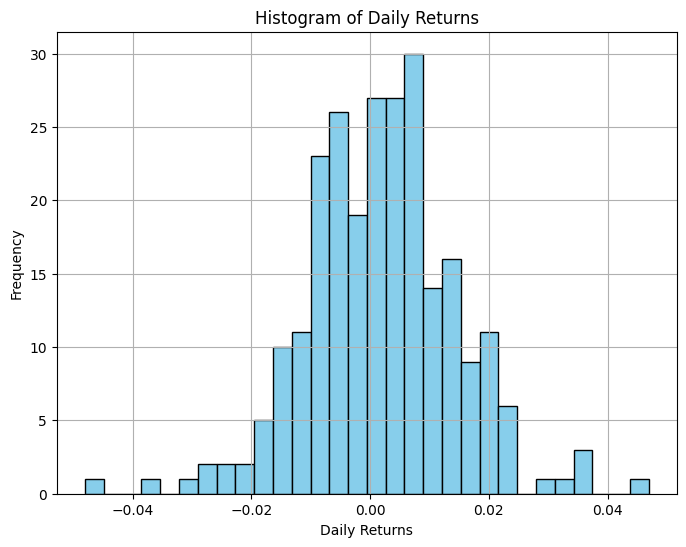

In [8]:
# Calculate daily returns
daily_returns = data['Close'].pct_change().dropna()
print(daily_returns)
# Plot histogram
plt.figure(figsize=(8, 6))
plt.hist(daily_returns, bins=30, color='skyblue', edgecolor='black')
plt.title('Histogram of Daily Returns')
plt.xlabel('Daily Returns')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


***Plot :The percentage change in stock prices over time***

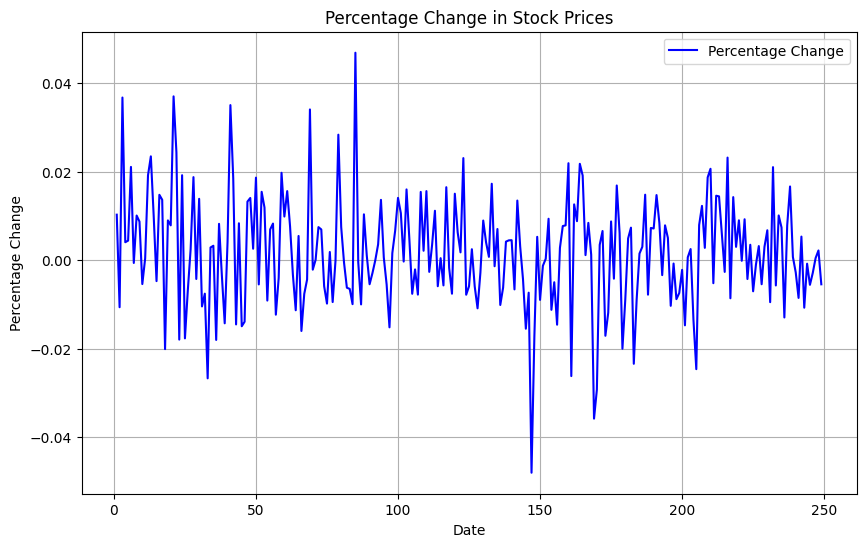

In [9]:

plt.figure(figsize=(10, 6))
plt.plot( data['Close'].pct_change(), label='Percentage Change', color='blue')
plt.title('Percentage Change in Stock Prices')
plt.xlabel('Date')
plt.ylabel('Percentage Change')
plt.legend()
plt.grid(True)
plt.show()


**Seasonal decomposition of the stock data into trend, seasonal, and residual components.**

*We can see that there is no seasonality, an increasing trend, and no residuals.*


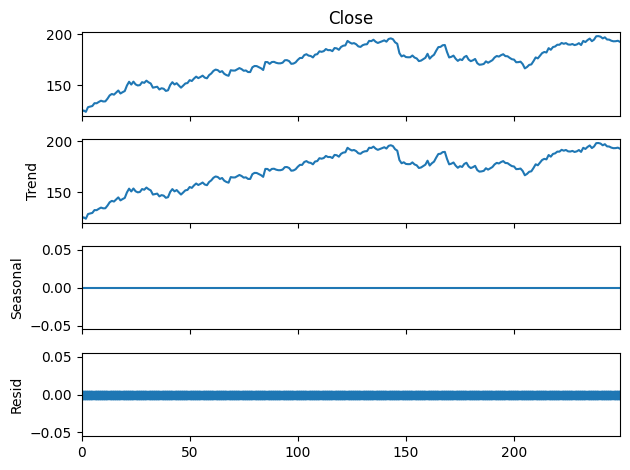

In [10]:
decomposition = sm.tsa.seasonal_decompose(data['Close'], model='additive',period=1)
fig = decomposition.plot()
plt.show()

In [11]:
def kpss_test(timeseries):
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression='c', nlags="auto")
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','#Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)

In [12]:

def adf_test(timeseries):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

**Dickey-Fuller Test:**

**Inference:**
The Dickey-Fuller test statistic (-2.586111) is greater than the critical values at all common significance levels (1%, 5%, and 10%). Additionally, the p-value (0.095902) is greater than the significance level of 0.05. Therefore, we fail to reject the null hypothesis of the Dickey-Fuller test. This suggests that the time series data is non-stationary.


In [13]:
adf_test(data['Close'])

Results of Dickey-Fuller Test:
Test Statistic                  -2.586111
p-value                          0.095902
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


**KPSS Test:**

**Inference:**
The KPSS test statistic (1.715955) is greater than the critical values at all common significance levels (10%, 5%, 2.5%, and 1%). Additionally, the p-value (0.010000) is less than the significance level of 0.05. Therefore, we reject the null hypothesis of the KPSS test. This suggests that the time series data is non-stationary.


In [14]:
kpss_test(data['Close'])

Results of KPSS Test:
Test Statistic            1.715955
p-value                   0.010000
#Lags Used               10.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


***Interpreting ACF (Autocorrelation Function) Plot:***
*Q values is 18*

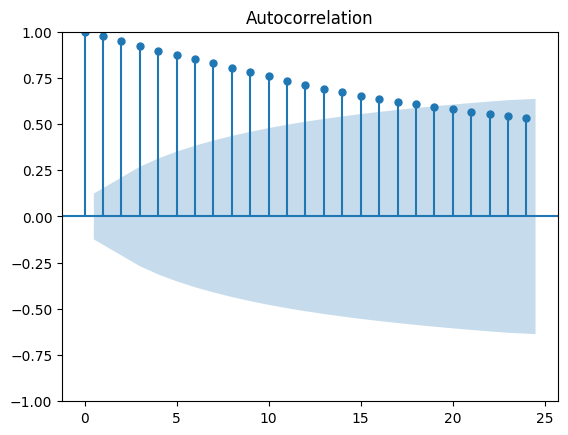

In [15]:
plot_acf(data['Close'])
plt.show()

***Interpreting PACF (Partial Autocorrelation Function) Plot:***
*P values is 1*

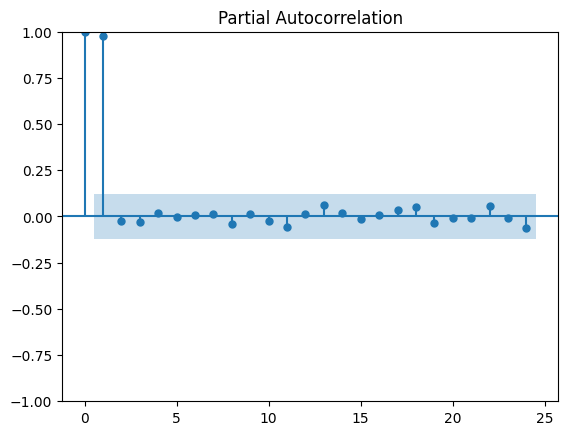

In [16]:
plot_pacf(data['Close'])
plt.show()

**First-order differencing on the stock closing prices and plots both the original and differenced data, demonstrating the removal of trend.**


Additionally, it conducts a KPSS test on the differenced data to assess stationarity.


**Inference:**
The KPSS test statistic (0.256073) is less than the critical values at all common significance levels (10%, 5%, 2.5%, and 1%). Additionally, the p-value (0.100000) is greater than the significance level of 0.05. Therefore, we fail to reject the null hypothesis of the KPSS test. This suggests that the differenced data is stationary.


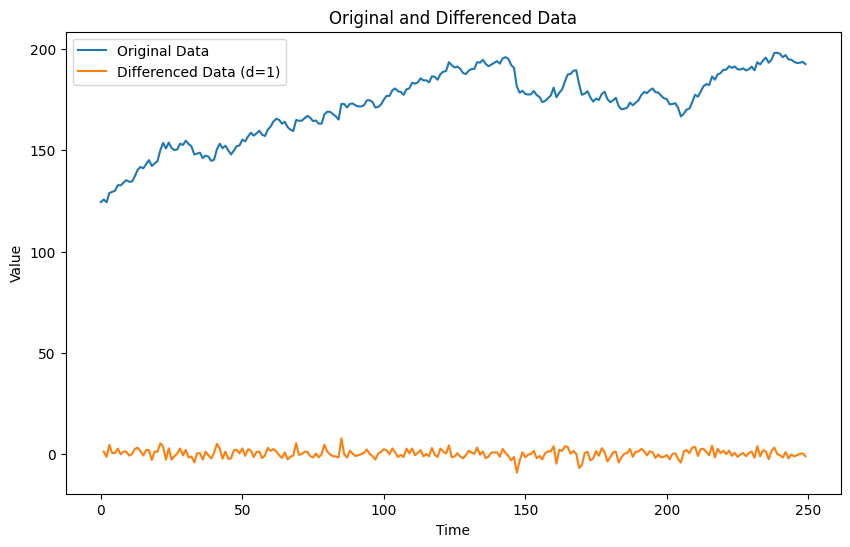

Results of KPSS Test:
Test Statistic           0.256073
p-value                  0.100000
#Lags Used               3.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


In [17]:
import pandas as pd
d = 1
time_data=data['Close']
differenced_data = time_data.diff(periods=d)
differenced_data = differenced_data.dropna()
plt.figure(figsize=(10, 6))
plt.plot(time_data, label='Original Data')
plt.plot(differenced_data, label='Differenced Data (d=1)')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Original and Differenced Data')
plt.legend()
plt.show()
kpss_test(differenced_data)


**Description:**

*This code snippet fits an ARIMA model with order (1,1,18) to the time series data, performs walk-forward validation to generate predictions for the test set, evaluates the performance of the forecasts using the root mean squared error (RMSE), and plots the actual test data against the predicted values.*


In [20]:

# Assuming 'data' is your DataFrame containing the time series data

X = data['Close'].values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()

# walk-forward validation
for t in range(len(test)):
    model = ARIMA(history, order=(1,1,18))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))

# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)



predicted=182.303998, expected=187.403000
predicted=188.108668, expected=187.623000
predicted=186.536458, expected=189.211000
predicted=188.028443, expected=189.450000
predicted=189.798631, expected=182.669000
predicted=182.270050, expected=177.326000
predicted=178.193353, expected=177.946000
predicted=178.104254, expected=179.124000
predicted=182.661783, expected=176.068000
predicted=177.205262, expected=173.981000
predicted=175.153938, expected=175.509000
predicted=173.873050, expected=174.780000
predicted=171.466133, expected=177.736000
predicted=177.566031, expected=178.834000
predicted=175.915413, expected=175.259000
predicted=175.762972, expected=173.701000
predicted=173.420708, expected=174.560000
predicted=173.476517, expected=175.848000
predicted=175.834742, expected=171.734000
predicted=170.935627, expected=170.206000
predicted=172.617233, expected=170.465000
predicted=173.223599, expected=170.985000
predicted=172.065037, expected=173.521000
predicted=172.645749, expected=172

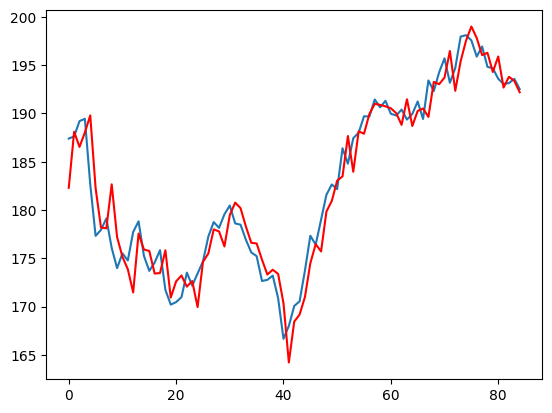

In [22]:
# plot forecasts against actual outcomes
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

In [23]:
def predict_by_date(days):
  X = data['Close'].values
  train = X
  history = [x for x in train]
  predictions = list()

  # Fit the ARIMA model
  model = ARIMA(history, order=(1, 1, 18))
  model_fit = model.fit()

  # Forecast
  output = model_fit.forecast(steps=days)
  return output


In [24]:
def get_day_of_week(date_string):
    try:
        # Get the day of the week as an integer (Monday=0, Sunday=6)
        day_of_week = date_string.weekday()
        # Convert the integer day of the week to a string representation
        days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
        day_name = days[day_of_week]
        return day_name
    except ValueError:
        return "Invalid date format. Please provide date in YYYY-MM-DD format."

In [25]:
def count_weekdays(start_date, end_date):
    if start_date > end_date:
        print("Error: The start date should be earlier than the end date.")
        return -1
    elif get_day_of_week(end_date) in ['Saturday', 'Sunday']:  # Check if end date is weekend
        print("It's " + get_day_of_week(end_date) + ", we can't buy Stocks")
        return -1
    else:
        current_date = start_date + timedelta(days=1)  # Start counting from the day after the start date
        weekdays_count = 0
        weekdays_dates = []
        while current_date < end_date:  # Stop before the end date
            if current_date.weekday() < 5:  # Monday to Friday (0 to 4)
                weekdays_count += 1
                weekdays_dates.append(current_date.strftime('%Y-%m-%d'))
            current_date += timedelta(days=1)
        return weekdays_count, weekdays_dates



**Description:**

*This code snippet takes a given date and a last date, counts the weekdays between them, predicts values for those weekdays, creates a new DataFrame with the predicted values, appends it to the existing data, creates a new model with the updated data, visualizes the transition probability of the new model, and decides whether to buy based on the updated portfolio values.*

   Field        Date       Close
0  Close  2024-01-01  192.138310
1  Close  2024-01-02  191.461618
2  Close  2024-01-03  191.697334
3  Close  2024-01-04  192.438136
4  Close  2024-01-05  191.699032
5  Close  2024-01-08  190.986888
6  Close  2024-01-09  191.024686


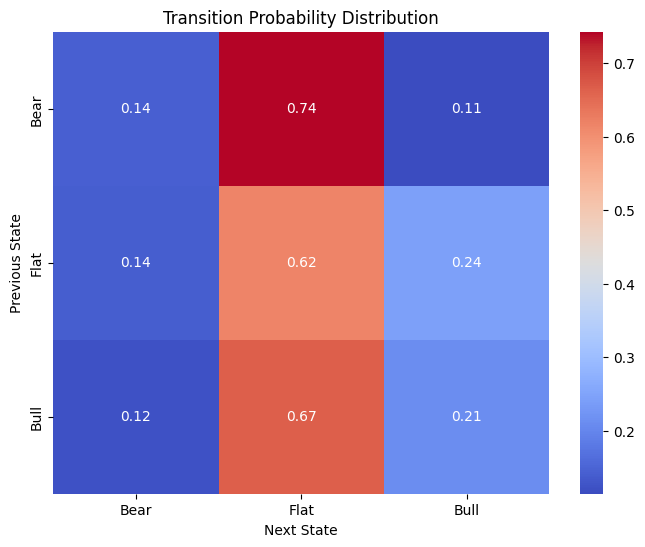

Matrix with Indices:
           Bear       Flat       Bull      
Bear       0.14       0.74       0.11      
Flat       0.14       0.62       0.24      
Bull       0.12       0.67       0.21      
Portfolio_value :  17
Buy_Indices :  [1, 6, 8, 12, 16, 21, 28, 30, 41, 50, 52, 59, 61, 69, 79, 85, 88, 94, 100, 103, 108, 110, 113, 117, 120, 123, 133, 142, 160, 164, 177, 187, 191, 207, 209, 212, 216, 218, 232, 234, 238]
Buy_Dates :  ['2023-01-04', '2023-01-11', '2023-01-13', '2023-01-20', '2023-01-26', '2023-02-02', '2023-02-13', '2023-02-15', '2023-03-03', '2023-03-16', '2023-03-20', '2023-03-29', '2023-03-31', '2023-04-13', '2023-04-27', '2023-05-05', '2023-05-10', '2023-05-18', '2023-05-26', '2023-06-01', '2023-06-08', '2023-06-12', '2023-06-15', '2023-06-22', '2023-06-27', '2023-06-30', '2023-07-17', '2023-07-28', '2023-08-23', '2023-08-29', '2023-09-18', '2023-10-02', '2023-10-06', '2023-10-30', '2023-11-01', '2023-11-06', '2023-11-10', '2023-11-14', '2023-12-05', '2023-12-07', '2023-1

In [26]:
given_date = datetime(2023, 12, 29)
last_date = datetime(2024, 1, 10)

# Count weekdays between given_date and last_date
weekdays_count, dates = count_weekdays(given_date, last_date)

# If there are weekdays to predict
if weekdays_count != 0:
    # Predict values for weekdays
    predicted_values = predict_by_date(weekdays_count)

    # If prediction is successful
    if predicted_values is not None:
        # Create DataFrame for new data
        data_dict = {'Field':'Close','Date': dates, 'Close': predicted_values}
        new_data = pd.DataFrame(data_dict)
        print(new_data)

        # Append new data to existing data
        new_data = data.append(new_data, ignore_index=True)

        # Create a new model with updated data
        new_model = Model(new_data)

        # Visualize transition probability of the new model
        new_model.visualize_transition_probability()

        # Decide whether to buy based on the updated portfolio values
        new_model.decide_buy()
    else:
        print("Prediction failed.")
else:
    print("No weekdays to predict.")
